In [1]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [2]:
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt

In [3]:
df = pd.read_csv('../Data/ABIDE_df2.csv')
df = df.iloc[~pd.isna(df['bids_folder']).values]
df = df.sort_values(by='bids_folder')
print(len(df))
df.head(3)

1048


,participant_id,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,PIQ,...,WISC_IV_MATRIX_SCALED,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI,bids_folder,site
460,50642,1,1.0,33.0,1,R,NaN,103.0,98.0,107.0,...,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-CMUa0050642,1
464,50646,1,1.0,21.0,1,R,NaN,108.0,100.0,115.0,...,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-CMUa0050646,1
465,50647,1,1.0,27.0,1,R,NaN,104.0,97.0,109.0,...,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-CMUa0050647,1


In [4]:
data_dir = '../Assets/abide_1_cmats'

In [5]:
cData = np.array([np.load(os.path.join(data_dir,sub+'.npy')) for sub in df['bids_folder'].values])

print(f'Original data range: {(cData.min(),cData.max())}')
cData = (cData+1)/2
print(f'Normalized data range: {(cData.min(),cData.max())}')
cData.shape

Original data range: (-0.8921183414567456, 1.0)
Normalized data range: (0.05394082927162719, 1.0)


(1048, 51, 51)

In [6]:
from tensorflow.keras.layers import ZeroPadding2D
pad2d = ZeroPadding2D(padding=((6,7),(6,7))) #If tuple of 2 tuples of 2 ints: interpreted as ((top_pad, bottom_pad

In [7]:
cData_pad = pad2d(cData[:,:,:,np.newaxis])
cData_pad.shape


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



TensorShape([1048, 64, 64, 1])

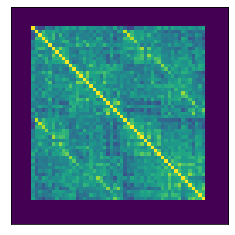

In [8]:
plt.imshow(cData_pad[0,:,:,0]);plt.xticks([]);plt.yticks([]);

## DEFINE MODEL AND LOAD WEIGHTS

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import regularizers
import os
import pandas as pd

def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
      args (tensor): mean and log of variance of Q(z|X)
    # Returns:
      z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def get_fMRI_CVAE_3D(input_shape=(51,51,1),
                     latent_dim=[2,2],
                     beta=1,
                     disentangle=False,
                     gamma=1,
                     bias=True,
                     batch_size = 32,
                     kernel_size = 3,
                     filters = 16,
                     intermediate_dim = 128,
                     nlayers = 2,
                     learning_rate=0.001,
                     opt=None):
    
    
    ndim_bg = latent_dim[0]
    ndim_sl = latent_dim[1]
    
    image_size, _, channels = input_shape

    kernel_regularizer=regularizers.l2(.0001)

    # build encoder model
    tg_inputs = Input(shape=input_shape, name='tg_inputs')
    bg_inputs = Input(shape=input_shape, name='bg_inputs')
    
    BatchNorm = tf.keras.layers.BatchNormalization(
    axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
    beta_initializer='zeros', gamma_initializer='ones',
    moving_mean_initializer='zeros',
    moving_variance_initializer='ones', beta_regularizer=None,
    gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

    #kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0,stddev=5)
    kernel_initializer = tf.keras.initializers.RandomUniform()

    # generate latent vector Q(z|X)
    
    
    z_h_layer = Dense(intermediate_dim,activation='relu', use_bias=bias,kernel_regularizer=kernel_regularizer)
    z_mean_layer = Dense(ndim_bg, name='z_mean', use_bias=bias,kernel_regularizer=kernel_regularizer)
    z_log_var_layer = Dense(ndim_bg, name='z_log_var', use_bias=bias,kernel_regularizer=kernel_regularizer)
    z_layer = Lambda(sampling, output_shape=(ndim_bg,), name='z')

    def z_encoder_func(inputs):
        z_h = inputs

        these_filters = filters
        for i in range(nlayers):
            these_filters *= 2
            #print(these_filters)
            z_h = Conv2D(filters=these_filters,
                    kernel_size=kernel_size,
                    activation='relu',
                    strides=2,
                    padding='same',
                    use_bias=bias,
                    kernel_regularizer=kernel_regularizer)(z_h)
        
        # shape info needed to build decoder model
        shape = K.int_shape(z_h)
        z_h = Flatten()(z_h)
        z_h = z_h_layer(z_h)
        z_mean =  z_mean_layer(z_h)
        #z_mean = BatchNorm(z_mean)
        
        z_log_var =  z_log_var_layer(z_h)
        z = z_layer([z_mean, z_log_var])
        return z_mean, z_log_var, z, shape

    tg_z_mean, tg_z_log_var, tg_z, shape_z = z_encoder_func(tg_inputs)

    # generate latent vector Q(z|X)
    s_h_layer = Dense(intermediate_dim, activation='relu', use_bias=bias,kernel_regularizer=kernel_regularizer)
    s_mean_layer = Dense(ndim_sl, name='s_mean', use_bias=bias,kernel_regularizer=kernel_regularizer)
    s_log_var_layer = Dense(ndim_sl, name='s_log_var', use_bias=bias,kernel_regularizer=kernel_regularizer)
    s_layer = Lambda(sampling, output_shape=(ndim_sl,), name='s')

    def s_encoder_func(inputs):
        s_h = inputs
        these_filters = filters
        for i in range(nlayers):
            these_filters *= 2
            s_h = Conv2D(filters=these_filters,
                    kernel_size=kernel_size,
                    activation='relu',
                    strides=2,
                    use_bias=bias,
                    kernel_regularizer=kernel_regularizer,
                    padding='same')(s_h)
        
        # shape info needed to build decoder model
        shape = K.int_shape(s_h)
        s_h = Flatten()(s_h)
        s_h = s_h_layer(s_h)
        s_mean =  s_mean_layer(s_h)
        #s_mean = BatchNorm(s_mean)
        
        s_log_var =  s_log_var_layer(s_h)        
        s = s_layer([s_mean, s_log_var])
        
        return s_mean, s_log_var, s, shape

    tg_s_mean, tg_s_log_var, tg_s, shape_s = s_encoder_func(tg_inputs)
    bg_z_mean, bg_z_log_var, bg_z, _ = z_encoder_func(bg_inputs) # Aidas and Stefano team hax
    
    
    # instantiate encoder models
    z_encoder = tf.keras.models.Model(tg_inputs, [tg_z_mean, tg_z_log_var, tg_z], name='z_encoder')
    s_encoder = tf.keras.models.Model(tg_inputs, [tg_s_mean, tg_s_log_var, tg_s], name='s_encoder')


    # build decoder model
    latent_inputs = Input(shape=(ndim_bg+ndim_sl,), name='z_sampling')

    x = Dense(intermediate_dim, activation='relu', use_bias=bias,kernel_regularizer=kernel_regularizer,kernel_initializer=kernel_initializer)(latent_inputs)
    x = Dense(shape_z[1] * shape_z[2] * shape_z[3], activation='relu', use_bias=bias,kernel_regularizer=kernel_regularizer,kernel_initializer=kernel_initializer)(x)
    x = Reshape((shape_z[1], shape_z[2], shape_z[3]))(x)

    these_filters = filters*(2**nlayers)/2
    for i in range(nlayers-1):
        x = Conv2DTranspose(filters=these_filters,
                          kernel_size=kernel_size,
                          activation='relu',
                          strides=2,
                          use_bias=bias,
                          kernel_regularizer=kernel_regularizer,
                          padding='same')(x)
        these_filters //= 2

    outputs = Conv2DTranspose(filters=channels,
                            kernel_size=kernel_size,
                            activation='sigmoid',
                            padding='same',
                            strides=2,
                            use_bias=bias,
                            kernel_regularizer=kernel_regularizer,
                            name='decoder_output')(x)

    # instantiate decoder model
    cvae_decoder = Model(latent_inputs, outputs, name='decoder')
      # decoder.summary()

    def zeros_like(x):
        return tf.zeros_like(x)

    tg_outputs = cvae_decoder(tf.keras.layers.concatenate([tg_z, tg_s], -1))
    zeros = tf.keras.layers.Lambda(zeros_like)(tg_s)

    bg_outputs = cvae_decoder(tf.keras.layers.concatenate([bg_z, zeros], -1)) # Aidas look into this, is this correct

    cvae = tf.keras.models.Model(inputs=[tg_inputs, bg_inputs], 
                                  outputs=[tg_outputs, bg_outputs],
                                  name='contrastive_vae')

#     cvae_fg = tf.keras.models.Model(inputs=tg_inputs, 
#                                   outputs=fg_outputs, 
#                                   name='contrastive_vae_fg')

    if disentangle:
        discriminator = Dense(1, activation='sigmoid')

        z1 = Lambda(lambda x: x[:int(batch_size/2),:])(tg_z)
        z2 = Lambda(lambda x: x[int(batch_size/2):,:])(tg_z)
        s1 = Lambda(lambda x: x[:int(batch_size/2),:])(tg_s)
        s2 = Lambda(lambda x: x[int(batch_size/2):,:])(tg_s)

        q_bar = tf.keras.layers.concatenate(
          [tf.keras.layers.concatenate([s1, z2], axis=1),
          tf.keras.layers.concatenate([s2, z1], axis=1)],
          axis=0)

        q = tf.keras.layers.concatenate(
          [tf.keras.layers.concatenate([s1, z1], axis=1),
          tf.keras.layers.concatenate([s2, z2], axis=1)],
          axis=0)

        q_bar_score = (discriminator(q_bar)+.1) *.85 # +.1 * .85 so that it's 0<x<1
        q_score = (discriminator(q)+.1) *.85 
        tc_loss = K.log(q_score / (1 - q_score)) 
        discriminator_loss = - K.log(q_score) - K.log(1 - q_bar_score)
    else:
        tc_loss = 0
        discriminator_loss = 0


    reconstruction_loss = tf.keras.losses.mse(K.flatten(tg_inputs[:,6:57,6:57,:]), K.flatten(tg_outputs[:,6:57,6:57,:])) 
    reconstruction_loss += tf.keras.losses.mse(K.flatten(bg_inputs[:,6:57,6:57,:]), K.flatten(bg_outputs[:,6:57,6:57,:])) 
    reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2]

    kl_loss1 = 1 + tg_z_log_var - tf.keras.backend.square(tg_z_mean) - tf.keras.backend.exp(tg_z_log_var)
    kl_loss2 = 1 + tg_s_log_var - tf.keras.backend.square(tg_s_mean) - tf.keras.backend.exp(tg_s_log_var)
    kl_loss3 = 1 + bg_z_log_var - tf.keras.backend.square(bg_z_mean) - tf.keras.backend.exp(bg_z_log_var)

    kl_loss1 = tf.keras.backend.sum(kl_loss1, axis=-1)
    kl_loss2 = tf.keras.backend.sum(kl_loss2, axis=-1)
    kl_loss3 = tf.keras.backend.sum(kl_loss3, axis=-1)

    kl_loss = kl_loss1+kl_loss2+kl_loss3
    #kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    
    cvae_loss = tf.keras.backend.mean(reconstruction_loss + beta*kl_loss + gamma*tc_loss + discriminator_loss)
    cvae.add_loss(cvae_loss)
    
    if type(opt)==type(None):
        #print('optimizer not specified using ADAM, wroom wroom')
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False,name='Adam')
        #opt = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.9, epsilon=1e-07, centered=False, name='RMSprop')
        #opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.1, nesterov=False, name='SGD')


    cvae.compile(optimizer=opt,run_eagerly=True)
    
    return cvae, z_encoder, s_encoder, cvae_decoder

In [10]:
#import make_models;reload(make_models);from make_models import *

batch_size = 32
cvae, z_encoder, s_encoder, cvae_decoder = get_fMRI_CVAE_3D(input_shape=(64,64,1),
                                                             latent_dim=[64,16],
                                                             beta=.001,
                                                             gamma=1,
                                                             disentangle=True,
                                                             bias=True,
                                                             batch_size = batch_size,
                                                             kernel_size = 3,
                                                             filters = 8,
                                                             intermediate_dim = 128,
                                                             nlayers = 4,
                                                             learning_rate=0.001,
                                                             opt=None)

num_params = np.sum([np.prod(val.get_shape()) for val in cvae.trainable_weights])
print(f'# params| {num_params:,}')

# params| 1,208,306


In [11]:
weights_dir = '../Assets/tf_weights/'
#analysis_name = 'CVAE_2021-10-27 11:41:44.052073'
analysis_name = 'CVAE_2021-10-28 05:12:17.623449'
weights_fn = os.path.join(weights_dir,analysis_name,'cvae_weights')

In [12]:
cvae.load_weights(weights_fn)

## GET DATA

In [13]:
patients = df['DX_GROUP'].values==1

In [14]:
use_data = cData_pad

Z_mu,Z_sigma,Z = z_encoder.predict(use_data)
S_mu,S_sigma,S = s_encoder.predict(use_data)

In [15]:
from tqdm import tqdm

In [16]:
z_samples = np.array([z_encoder.predict(use_data)[2] for i in tqdm(range(100))])
s_samples = np.array([s_encoder.predict(use_data)[2] for i in tqdm(range(100))])

100%|██████████| 100/100 [00:08<00:00, 11.91it/s]


In [17]:
z_samples.shape

(100, 1048, 64)

In [18]:
import umap
reducer = umap.UMAP(n_components=2)

In [19]:
s_embedding = reducer.fit_transform(S[patients,:])
z_embedding = reducer.fit_transform(Z[patients,:])

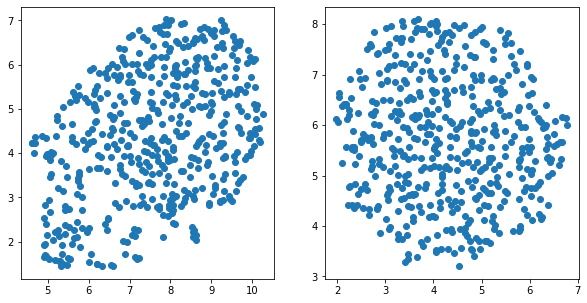

In [20]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,2);plt.scatter(z_embedding[:,0],z_embedding[:,1])
plt.subplot(1,2,1);plt.scatter(s_embedding[:,0],s_embedding[:,1])

In [21]:
def predict_cmat(s,is_asd,idx=None):
    # s = 0
    # idx=None
    # is_asd = patients[s]
    # is_asd = False

    if type(idx)==type(None):
        bg_vec = Z[s,:]
        sl_vec = S[s,:]
    else:
        bg_vec = z_samples[idx,s,:]
        sl_vec = s_samples[idx,s,:]

    zeroes_ = np.zeros(sl_vec.shape)

    if is_asd:
        vec = np.hstack((bg_vec,sl_vec))
    else:
        vec = np.hstack((bg_vec,zeroes_))

    predicted = cvae_decoder.predict(vec[np.newaxis,:])[0,:,:,0]
    predicted_depad = predicted[6:57,6:57]
    
    return predicted_depad

In [22]:
predicted = np.array([predict_cmat(s,patients[s],idx=None) for s in tqdm(range(len(df)))])
predicted_bg = np.array([predict_cmat(s,False,idx=None) for s in tqdm(range(len(df)))])

100%|██████████| 1048/1048 [00:30<00:00, 34.35it/s]


In [23]:
# predicted_samples = np.zeros((100,len(df),51,51))
# predicted_bg_samples = np.zeros((100,len(df),51,51))
# for s in tqdm(range(len(df))):
#     for idx in range(100):
#         predicted_samples[idx,s,:,:] = predict_cmat(s,patients[s],idx=idx)
#         predicted_bg_samples[idx,s,:,:] = predict_cmat(s,False,idx=idx)

In [24]:
latent_data = dict()

In [25]:
latent_data['cData'] = cData

In [26]:
latent_data['Z_mu'] = Z_mu
latent_data['Z_sigma'] = Z_sigma
latent_data['Z'] = Z

latent_data['S_mu'] = S_mu
latent_data['S_sigma'] = S_sigma
latent_data['S'] = S

latent_data['z_samples'] = z_samples
latent_data['s_samples'] = s_samples

latent_data['z_embedding'] = z_embedding
latent_data['s_embedding'] = s_embedding

latent_data['predicted'] = predicted
latent_data['predicted_bg'] = predicted_bg

In [27]:
analysis_name

'CVAE_2021-10-28 05:12:17.623449'

In [28]:
ofn = os.path.join('../Data',f'cmat_latents_{analysis_name}.pickle')
ofn

'../Data/cmat_latents_CVAE_2021-10-28 05:12:17.623449.pickle'

In [29]:
import pickle
pickle.dump(obj=latent_data,file=open(ofn,'wb'))